# 1. Import Packages and Define Functions

In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
import xgboost
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
seed=42
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tweet = str(tweet).lower()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [5]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https", "rt"]
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [6]:
stopwords = list(set(stopwords))

In [7]:
def remove_http(tweet):
    pattern = '((http|https)\w+\s\w+\s\w+\s\w+)'
    try:
        return tweet.replace(re.findall(pattern, tweet)[0][0], "")
    except:
        return tweet

In [8]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [9]:
def check_profanity(tweet):
    profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tweet)

In [10]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [11]:
def fix_spelling(tweet):
    b = TextBlob(tweet)
    return b.correct()

In [12]:
def get_subjectivity(tweet):
    b = TextBlob(tweet)
    return b.sentiment.subjectivity

In [13]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
  
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [14]:
def remove_username(tweet):
    try:
        p = '[\w\s]+(@\w+)'
        return tweet.replace(re.findall(p, tweet)[0], "")
    except:
        return tweet

In [15]:
def ReplaceThreeOrMore(tweet):
    # pattern to look for three or more repetitions of any character, including
    # newlines.
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL) 
    return pattern.sub(r"\1\1", tweet)

In [16]:
def clean_txt(tweet):
    tweet = remove_http(tweet)
    tweet = remove_username(tweet)
    tweet = ReplaceThreeOrMore(tweet)
    tokens = process_tweet(tweet)
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    

In [17]:
analyzer = SentimentIntensityAnalyzer()
def return_sentiment(tweet):
    return analyzer.polarity_scores(tweet)['compound']

# 2. Load in Data and Preprocess

In [18]:
df = pd.read_csv("tweets_4_classes.csv").drop(['Unnamed: 0', 'emoji_frequency'], axis=1)
df.head()

,tweet,sentiment_score,exclamation_points,top_emoji
0,i dont want to vote for pedophile biden im sor...,-0.7447,0.000000,😩
1,I ll kidnap 1000 children before I let this co...,-0.2942,0.010101,😊
2,omg there s more on the ballot then just the p...,-0.7003,0.000000,😱
3,AméricaniseUnTitre The Trump Tower Infernale,0.4588,0.000000,😊
4,Biden will WIN Trump and DeJoy have cheated!! ...,0.5437,0.021429,😊


In [19]:
print(df.tweet.iloc[0])
print(clean_txt(df.tweet.iloc[0]))
print(type(clean_txt(df.tweet.iloc[0])))

i dont want to vote for pedophile biden im sorry what
dont want vote pedophile biden im sorry
<class 'str'>


In [20]:
# # Remove "http link stuff from all the tweets"
# print(df.tweet.iloc[0])
# print(remove_http(df.tweet.iloc[0]))

# df.tweet = df.tweet.apply(remove_http)

In [21]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
normalizer = MinMaxScaler()
df.sentiment_score = normalizer.fit_transform(np.array(df.sentiment_score).reshape(-1,1))
df.sentiment_score.describe()

count    3654.000000
mean        0.591639
std         0.309474
min         0.000000
25%         0.290590
50%         0.690462
75%         0.871406
max         1.000000
Name: sentiment_score, dtype: float64

In [22]:
df['capitalization'] = df.tweet.progress_apply(capital_percentage)
df.head()

100%|██████████| 3654/3654 [00:00<00:00, 7801.93it/s]


,tweet,sentiment_score,exclamation_points,top_emoji,capitalization
0,i dont want to vote for pedophile biden im sor...,0.126140,0.000000,😩,0.000000
1,I ll kidnap 1000 children before I let this co...,0.351818,0.010101,😊,0.111111
2,omg there s more on the ballot then just the p...,0.148382,0.000000,😱,0.000000
3,AméricaniseUnTitre The Trump Tower Infernale,0.729035,0.000000,😊,0.000000
4,Biden will WIN Trump and DeJoy have cheated!! ...,0.771566,0.021429,😊,0.037037


In [23]:
df['profanity'] = df.tweet.progress_apply(check_profanity)
df.head()

100%|██████████| 3654/3654 [00:07<00:00, 488.52it/s]


,tweet,sentiment_score,exclamation_points,top_emoji,capitalization,profanity
0,i dont want to vote for pedophile biden im sor...,0.126140,0.000000,😩,0.000000,0.000000
1,I ll kidnap 1000 children before I let this co...,0.351818,0.010101,😊,0.111111,0.010753
2,omg there s more on the ballot then just the p...,0.148382,0.000000,😱,0.000000,0.000000
3,AméricaniseUnTitre The Trump Tower Infernale,0.729035,0.000000,😊,0.000000,0.000000
4,Biden will WIN Trump and DeJoy have cheated!! ...,0.771566,0.021429,😊,0.037037,0.007576


In [24]:
df['subjectivity'] = df.tweet.progress_apply(get_subjectivity)

100%|██████████| 3654/3654 [00:00<00:00, 5262.65it/s]


In [25]:
# test the replacing of extra chars
test = "yoooooo let's!! gooooo to the zoooo!. Wazzzzuppppp!!!. AAABBBCCC"

In [26]:
ReplaceThreeOrMore(test)

"yoo let's!! goo to the zoo!. Wazzupp!!. AABBCC"

In [27]:
df.top_emoji.value_counts()

😊    2058
😩     831
😡     517
😱     248
Name: top_emoji, dtype: int64

Here we see a very clear and large class imbalance. In this notebook, all models try to handle this inbalance by balancing the weights given to each class.

Text(0, 0.5, 'Count')

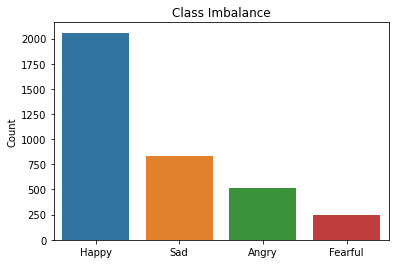

In [28]:
x_ax = ['Happy', 'Sad', 'Angry', 'Fearful']
y = df.top_emoji.value_counts()
sns.barplot(x_ax, y)
plt.title("Class Imbalance")
plt.ylabel("Count")
#plt.savefig("../pics/class_imbalance.png")

# 3. Dummy Classifier for Baseline Model

In [29]:
X = df[['tweet', 'sentiment_score', 'capitalization', 'profanity','exclamation_points']]

In [30]:
y =df['top_emoji']

In [31]:
from sklearn.dummy import DummyClassifier

In [32]:
dummy_cf = DummyClassifier(strategy='uniform')
dummy_cf.fit(X['tweet'],y)
y_preds = dummy_cf.predict(X['tweet'])

print(dummy_cf.score(X['tweet'],y))

0.26053639846743293


In [33]:
accuracy = accuracy_score(y, y_preds)


In [34]:
results=[]
results.append(('Dummy', accuracy))

In [35]:
results

[('Dummy', 0.2651888341543514)]

In [36]:
df.top_emoji.value_counts()

😊    2058
😩     831
😡     517
😱     248
Name: top_emoji, dtype: int64

### This notebook uses class_weight = balanced, see other notebook for resampled results

In [37]:
# from sklearn.utils import resample
# cry = df[df.top_emoji == '😩']
# happy = df[df.top_emoji == '😊']
# fear = df[df.top_emoji == '😱']
# anger = df[df.top_emoji == '😡']


# cry_downsampled = resample(cry,
#                           replace=False,
#                           n_samples=int(len(fear)*1.5), # match number
#                           random_state=seed) 

# happy_downsampled = resample(happy,
#                           replace=False,
#                           n_samples=int(len(fear)*1.5), # match number 
#                           random_state=seed) 
# fear_upsampled = resample(fear,
#                           replace=True, 
#                           n_samples=int(len(fear)*1.5), # match number 
#                           random_state=seed) 
# anger_upsampled = resample(anger,
#                           replace=True,
#                           n_samples=int(len(fear)*1.5), # match number 
#                           random_state=seed) 

# df = pd.concat([cry_downsampled, happy_downsampled, fear_upsampled, anger_upsampled])
# df.top_emoji.value_counts()

In [38]:
X = df[['tweet', 'sentiment_score', 'capitalization', 'profanity','exclamation_points']]

In [39]:
y =df['top_emoji']

# 4. Supervised Learning

In [40]:
import en_core_web_sm
nlp = en_core_web_sm.load()
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        rs = []
        for row in data.iterrows():
            to_add = {}
            for item in row[1:]:
                for ind, val in zip(item.index, item.values):
                    to_add[ind] = val
            rs.append(to_add)
        return rs
#         return [{'cap':  row['capitalization'], 'prof': row['profanity'], 
#                  'sent': row['sentiment_score'], 'excla': row['exclamation_points']} for _, row in data.iterrows()]

In [42]:
test = ItemSelector(['capitalization','sentiment_score','exclamation_points']).fit(X)

In [43]:
rs = []
for row in test.transform(X).iterrows():
    to_add = {}
    for item in row[1:]:
        for ind, val in zip(item.index, item.values):
            to_add[ind] = val
    rs.append(to_add)


In [44]:
rs[:2]

[{'capitalization': 0.0,
  'sentiment_score': 0.12613966536419197,
  'exclamation_points': 0.0},
 {'capitalization': 0.1111111111111111,
  'sentiment_score': 0.35181845506462284,
  'exclamation_points': 0.010101010101010102}]

### Pipeline to help in the creation of our training arrays to include custom features as well as TF IDF and Word Embeddings.

- NOTE: Word embeddings hurt the score, hence it is commented out.

In [45]:
def create_pipeline(input_selectors): 
    pipeline = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[

                # Pipeline for pulling features from the text
                ('text', Pipeline([
                    ('selector', ItemSelector(key='tweet')),
                    ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                        ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = None, preprocessor=clean_txt)),
                ])),

    #             ('embedding', Pipeline([
    #                 ('selector', ItemSelector(key='tweet')),
    #                 ("mean_embeddings", SpacyVectorTransformer(nlp))
    #             ])),

                # Pipeline for pulling metadata features
                ('stats', Pipeline([
                    ('selector', ItemSelector(key=input_selectors)),
                    ('stats', TextStats()),  # returns a list of dicts
                    ('vect', DictVectorizer()),  # list of dicts -> feature matrix
                ])),

            ],

            # weight components in FeatureUnion
            transformer_weights={
                'text': 1,#0.9,
    #             'embedding': 1,
                'stats': 1 #1.5,
            },
        ))
    ], verbose=True)
    
    return pipeline

['capitalization','profanity','sentiment_score','exclamation_points']

In [46]:
pipeline_cap = create_pipeline(['capitalization'])
pipeline_prof = create_pipeline(['profanity'])
pipeline_sent = create_pipeline(['sentiment_score'])
pipeline_excl = create_pipeline(['exclamation_points'])
pipeline_all = create_pipeline(['capitalization','profanity','sentiment_score','exclamation_points'])

In [47]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [48]:
pipeline_cap.fit(X_train)
pipeline_prof.fit(X_train)
pipeline_sent.fit(X_train)
pipeline_excl.fit(X_train)
pipeline_all.fit(X_train)

[Pipeline] ............. (step 1 of 1) Processing union, total=   0.9s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.9s
[Pipeline] ............. (step 1 of 1) Processing union, total=   1.3s
[Pipeline] ............. (step 1 of 1) Processing union, total=   2.1s
[Pipeline] ............. (step 1 of 1) Processing union, total=   2.3s


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='tweet')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  preprocessor=<function clean_txt at 0x120902040>,
                                                                                  smooth_idf=1,
                                                           

In [49]:
%%time
train_vec_cap = pipeline_cap.transform(X_train)
test_vec_cap = pipeline_cap.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec_cap.shape, test_vec_cap.shape))

train_vec_prof = pipeline_prof.transform(X_train)
test_vec_prof = pipeline_prof.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec_prof.shape, test_vec_prof.shape))

train_vec_sent = pipeline_sent.transform(X_train)
test_vec_sent = pipeline_sent.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec_sent.shape, test_vec_sent.shape))

train_vec_excl = pipeline_excl.transform(X_train)
test_vec_excl = pipeline_excl.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec_excl.shape, test_vec_excl.shape))

train_vec_all = pipeline_all.transform(X_train)
test_vec_all = pipeline_all.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec_all.shape, test_vec_all.shape))

Checking that the shapes match: (2923, 2021) - (731, 2021)
Checking that the shapes match: (2923, 2021) - (731, 2021)
Checking that the shapes match: (2923, 2021) - (731, 2021)
Checking that the shapes match: (2923, 2021) - (731, 2021)
Checking that the shapes match: (2923, 2024) - (731, 2024)
CPU times: user 7.54 s, sys: 70.5 ms, total: 7.61 s
Wall time: 8.65 s


In [50]:
trains = [train_vec_cap, train_vec_prof, train_vec_sent, train_vec_excl, train_vec_all]
tests = [test_vec_cap, test_vec_prof, test_vec_sent, test_vec_excl, test_vec_all]
labels = ['capitalization', 'profanity', 'sentiment_score', 'exclamation_points', 'all_custom']

## Create Overarching Function for Iterative Modeling
- Takes in a model
- Runs that model against all the different train/test vecs with dif features
- prints out accuracy and description of what train/test vec worked best
- prints out confusion matrix and classification report for best version of the model
- Returns best score 

In [51]:
def get_model_results(model, model_name, conditions=None, choices=None):
    res = []
    for train, test, label in zip(trains, tests, labels):
        if type(model) == xgboost.sklearn.XGBClassifier:
            model.fit(train, y_train, eval_metric='mlogloss', sample_weight = np.select(conditions, choices, None))
        else:
            model.fit(train, y_train)
        test_preds = model.predict(test)
        accuracy = accuracy_score(y_test, test_preds)
        res.append({'label': label, 'score': accuracy, 'test_preds': test_preds})
    res = sorted(res, key = lambda x: x['score'], reverse=True)
    print('RESULTS')
    print('-------------------------------------------------------------------------------------------------')
    print(f"{model_name} with {res[0]['label']} features performed the best with an accuracy of {res[0]['score']}")
    print('-------------------------------------------------------------------------------------------------')
    print(classification_report(y_test, res[0]['test_preds']))
    print('----------------------------------------')
    print(confusion_matrix(y_test, res[0]['test_preds']))
    return res[0]['score']

### LogReg

Algorithm to use in the optimization problem.

    - For small datasets, 'liblinear' is a good choice, whereas 'sag' and
      'saga' are faster for large ones.
    - For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs'
      handle multinomial loss; 'liblinear' is limited to one-versus-rest
      schemes.
    - 'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty, whereas
      'liblinear' and 'saga' handle L1 penalty.
    - 'liblinear' might be slower in LogisticRegressionCV because it does
      not handle warm-starting.


In [52]:
lr_clf = LogisticRegressionCV(solver='newton-cg', cv=10, penalty='l2', Cs = [.001,.01,.1,1,10,100], 
                                    max_iter=10000, verbose=True, n_jobs=-1, scoring='f1', multi_class='ovr',
                                class_weight='balanced')
results.append(('log reg', get_model_results(lr_clf, 'log reg')))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


RESULTS
-------------------------------------------------------------------------------------------------
log reg with all_custom features performed the best with an accuracy of 0.6990424076607387
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.90      0.89      0.89       412
           😡       0.41      0.39      0.40       103
           😩       0.51      0.56      0.53       166
           😱       0.26      0.22      0.24        50

    accuracy                           0.70       731
   macro avg       0.52      0.51      0.52       731
weighted avg       0.70      0.70      0.70       731

----------------------------------------
[[367  12  31   2]
 [ 22  40  30  11]
 [ 19  36  93  18]
 [  1  10  28  11]]


In [53]:
results

[('Dummy', 0.2651888341543514), ('log reg', 0.6990424076607387)]

### SVM(s)

#### LinearSVC

In [54]:
sv_clf = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=seed) 
results.append(('linear svc', get_model_results(sv_clf, 'linear svc')))

RESULTS
-------------------------------------------------------------------------------------------------
linear svc with all_custom features performed the best with an accuracy of 0.7277701778385773
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.89      0.92      0.91       412
           😡       0.44      0.37      0.40       103
           😩       0.55      0.63      0.59       166
           😱       0.34      0.20      0.25        50

    accuracy                           0.73       731
   macro avg       0.56      0.53      0.54       731
weighted avg       0.71      0.73      0.72       731

----------------------------------------
[[380   9  20   3]
 [ 23  38  37   5]
 [ 23  28 104  11]
 [  1  11  28  10]]


In [55]:
results

[('Dummy', 0.2651888341543514),
 ('log reg', 0.6990424076607387),
 ('linear svc', 0.7277701778385773)]

#### SVC

In [56]:
svc = SVC(C=15, class_weight='balanced', kernel='rbf', gamma='scale')
results.append(('svc', get_model_results(svc, 'svc')))

RESULTS
-------------------------------------------------------------------------------------------------
svc with all_custom features performed the best with an accuracy of 0.7400820793433652
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.89      0.92      0.91       412
           😡       0.47      0.37      0.42       103
           😩       0.55      0.66      0.60       166
           😱       0.56      0.28      0.37        50

    accuracy                           0.74       731
   macro avg       0.62      0.56      0.57       731
weighted avg       0.73      0.74      0.73       731

----------------------------------------
[[380   6  25   1]
 [ 23  38  39   3]
 [ 23  27 109   7]
 [  1   9  26  14]]


In [57]:
results

[('Dummy', 0.2651888341543514),
 ('log reg', 0.6990424076607387),
 ('linear svc', 0.7277701778385773),
 ('svc', 0.7400820793433652)]

### Random Forest

In [58]:
rfc_clf = RandomForestClassifier(n_estimators=400, random_state=seed,n_jobs=-1,
                                 class_weight='balanced',criterion='entropy' )
results.append(('rfc', get_model_results(rfc_clf, 'rfc')))


RESULTS
-------------------------------------------------------------------------------------------------
rfc with all_custom features performed the best with an accuracy of 0.771545827633379
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.88      0.93      0.91       412
           😡       0.60      0.44      0.51       103
           😩       0.60      0.77      0.67       166
           😱       1.00      0.14      0.25        50

    accuracy                           0.77       731
   macro avg       0.77      0.57      0.58       731
weighted avg       0.79      0.77      0.75       731

----------------------------------------
[[384   9  19   0]
 [ 22  45  36   0]
 [ 26  12 128   0]
 [  3   9  31   7]]


In [59]:
results

[('Dummy', 0.2651888341543514),
 ('log reg', 0.6990424076607387),
 ('linear svc', 0.7277701778385773),
 ('svc', 0.7400820793433652),
 ('rfc', 0.771545827633379)]

### MN Bayes

In [60]:
#Multinomial Naive Bayes
mnb_clf = MultinomialNB() 
results.append(('mn bayes', get_model_results(mnb_clf, 'mn bayes')))

RESULTS
-------------------------------------------------------------------------------------------------
mn bayes with sentiment_score features performed the best with an accuracy of 0.5964432284541724
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.61      0.97      0.75       412
           😡       0.55      0.12      0.19       103
           😩       0.43      0.12      0.19       166
           😱       1.00      0.06      0.11        50

    accuracy                           0.60       731
   macro avg       0.64      0.32      0.31       731
weighted avg       0.58      0.60      0.50       731

----------------------------------------
[[401   2   9   0]
 [ 82  12   9   0]
 [140   6  20   0]
 [ 36   2   9   3]]


In [61]:
results

[('Dummy', 0.2651888341543514),
 ('log reg', 0.6990424076607387),
 ('linear svc', 0.7277701778385773),
 ('svc', 0.7400820793433652),
 ('rfc', 0.771545827633379),
 ('mn bayes', 0.5964432284541724)]

### Bernoulli Bayes

In [62]:
#Bernoulli Naive Bayes
bb_clf = BernoulliNB() 
results.append(('bernoulli bayes', get_model_results(bb_clf, 'bernoulli bayes')))

RESULTS
-------------------------------------------------------------------------------------------------
bernoulli bayes with all_custom features performed the best with an accuracy of 0.6169630642954856
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.67      0.86      0.76       412
           😡       0.52      0.24      0.33       103
           😩       0.45      0.40      0.43       166
           😱       1.00      0.06      0.11        50

    accuracy                           0.62       731
   macro avg       0.66      0.39      0.41       731
weighted avg       0.62      0.62      0.58       731

----------------------------------------
[[356  13  43   0]
 [ 54  25  24   0]
 [ 92   7  67   0]
 [ 29   3  15   3]]


In [63]:
results

[('Dummy', 0.2651888341543514),
 ('log reg', 0.6990424076607387),
 ('linear svc', 0.7277701778385773),
 ('svc', 0.7400820793433652),
 ('rfc', 0.771545827633379),
 ('mn bayes', 0.5964432284541724),
 ('bernoulli bayes', 0.6169630642954856)]

### Passive Aggressive Classifier

In [64]:
#PassiveAggresive Classifier
pac_clf = PassiveAggressiveClassifier() 
results.append(('pac', get_model_results(pac_clf, 'pac')))

RESULTS
-------------------------------------------------------------------------------------------------
pac with all_custom features performed the best with an accuracy of 0.6880984952120383
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.86      0.88      0.87       412
           😡       0.42      0.38      0.40       103
           😩       0.53      0.55      0.54       166
           😱       0.23      0.18      0.20        50

    accuracy                           0.69       731
   macro avg       0.51      0.50      0.50       731
weighted avg       0.68      0.69      0.68       731

----------------------------------------
[[363  16  27   6]
 [ 26  39  29   9]
 [ 32  26  92  16]
 [  3  11  27   9]]


In [65]:
results

[('Dummy', 0.2651888341543514),
 ('log reg', 0.6990424076607387),
 ('linear svc', 0.7277701778385773),
 ('svc', 0.7400820793433652),
 ('rfc', 0.771545827633379),
 ('mn bayes', 0.5964432284541724),
 ('bernoulli bayes', 0.6169630642954856),
 ('pac', 0.6880984952120383)]

### XGBoost

In [66]:
conditions = [
   y_train=='😊', y_train=='😩',y_train== '😡',y_train=='😱'
]

choices = 1 / np.array(list(y_train.value_counts(normalize=True)))

In [67]:
xg = xgb.XGBClassifier(n_jobs=-1)
results.append(('xgboost', get_model_results(xg, 'xgboost', conditions, choices)))

RESULTS
-------------------------------------------------------------------------------------------------
xgboost with all_custom features performed the best with an accuracy of 0.7674418604651163
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.92      0.90      0.91       412
           😡       0.56      0.46      0.50       103
           😩       0.60      0.70      0.65       166
           😱       0.53      0.52      0.53        50

    accuracy                           0.77       731
   macro avg       0.65      0.65      0.65       731
weighted avg       0.77      0.77      0.77       731

----------------------------------------
[[371  14  23   4]
 [ 16  47  35   5]
 [ 17  18 117  14]
 [  0   5  19  26]]


In [68]:
results

[('Dummy', 0.2651888341543514),
 ('log reg', 0.6990424076607387),
 ('linear svc', 0.7277701778385773),
 ('svc', 0.7400820793433652),
 ('rfc', 0.771545827633379),
 ('mn bayes', 0.5964432284541724),
 ('bernoulli bayes', 0.6169630642954856),
 ('pac', 0.6880984952120383),
 ('xgboost', 0.7674418604651163)]

### Voting Classifier

In [69]:
voting_clf = VotingClassifier(
                estimators=[('logreg', lr_clf), ('svm_linear', sv_clf), ('pass_aggr', pac_clf),
                            ('svc', svc), ('xgboost', xg), ('rfc', rfc_clf),
                            ('mnbayes', mnb_clf),('berbayes', bb_clf)], #(
                voting='hard', verbose=1, n_jobs= -1)
results.append(('voting', get_model_results(voting_clf, 'voting')))

RESULTS
-------------------------------------------------------------------------------------------------
voting with all_custom features performed the best with an accuracy of 0.7414500683994528
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           😊       0.85      0.94      0.90       412
           😡       0.54      0.37      0.44       103
           😩       0.57      0.64      0.60       166
           😱       0.53      0.20      0.29        50

    accuracy                           0.74       731
   macro avg       0.62      0.54      0.56       731
weighted avg       0.72      0.74      0.72       731

----------------------------------------
[[388   5  19   0]
 [ 28  38  34   3]
 [ 36  18 106   6]
 [  2  10  28  10]]


In [70]:
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('rfc', 0.771545827633379),
 ('xgboost', 0.7674418604651163),
 ('voting', 0.7414500683994528),
 ('svc', 0.7400820793433652),
 ('linear svc', 0.7277701778385773),
 ('log reg', 0.6990424076607387),
 ('pac', 0.6880984952120383),
 ('bernoulli bayes', 0.6169630642954856),
 ('mn bayes', 0.5964432284541724),
 ('Dummy', 0.2651888341543514)]

### Bar Chart of Different Model Results

In [71]:
x = [x[0] for x in results]
y = [x[1] for x in results]

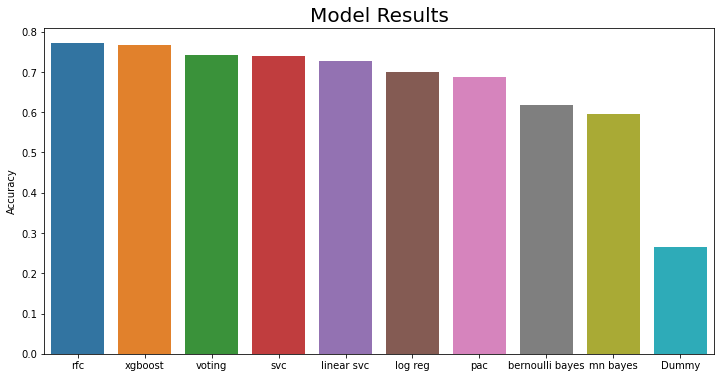

In [72]:
plt.figure(figsize=(12,6))
sns.barplot(x,y)
plt.ylabel('Accuracy')
plt.title("Model Results", fontsize=20)
plt.savefig("../pics/model_performances.png")